# Solving the Travelling Salesman Problem using Genetic Algorithm

The *Traveling Salesman Problem* (TSP) is a classic and extremely important optimisation problem in the field of operations research and computer science. It can be stated as follows: *Given a set of cities and the distances between each pair of cities, the goal is to find the shortest possible route that visits each city exactly once and returns back to the starting city.* The TSP is known to be a NP-hard problem, hence it doesn't have a known polynomial-time algorithm which solves it exactly. In this first lab session, we will try to leverage *Genetic Algorithm* (GA) to come up with a solution.

Let's start by importing some useful modules.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

We define a `City` class to handle our cities more easily. 

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __eq__(self, other_city):
        return isinstance(other_city, City) and self.x == other_city.x and self.y == other_city.y
    
    def __ne__(self, other_city):
        return not self == other_city
    
    def __hash__(self):
        # Use a hash of the tuple (self.x, self.y) to make City objects hashable
        return hash((self.x, self.y))
    
    def distance(self, city):
        dist = np.sqrt((self.x-city.x)**2 + (self.y-city.y)**2)
        return dist

Now we want a function to initialize our population. Remember that each route must contain each city **exactly once**.

In [3]:
def get_cities(n_cities, x_range, y_range):
    cities = []
    while len(cities) < n_cities:
        cities.append(City(x=int(random.random() * x_range), y=int(random.random() * y_range)))
        cities = list(set(cities))
    return cities


def init_population(cities, pop_size):
    init_pop = []
    for _ in range(pop_size):
        shuffled_list = cities.copy()
        random.shuffle(shuffled_list)
        init_pop.append(shuffled_list)
    return init_pop

In [6]:
cities = get_cities(5, 3, 3)
print(cities)
init_pop = init_population(cities=cities, pop_size=5)
print(init_pop)

[(2, 1), (0, 0), (1, 1), (2, 0), (0, 2)]
[[(0, 2), (0, 0), (2, 1), (1, 1), (2, 0)], [(0, 0), (2, 0), (2, 1), (1, 1), (0, 2)], [(1, 1), (2, 0), (0, 0), (0, 2), (2, 1)], [(0, 2), (1, 1), (0, 0), (2, 0), (2, 1)], [(0, 2), (2, 1), (0, 0), (1, 1), (2, 0)]]


We define the **fitness** as the inverse of the route distance. Since we want to minimise the distance, we want to maximise our fitness score.

In [8]:
def fitness_score(route):
    dist = 0
    for i in range(len(route)-1):
        dist += route[i].distance(route[i+1])
    dist += route[i].distance(route[0])
    return 1/dist

# fitness_score(init_pop[0])

We define now a function to perform **tournament selection** (or any other selection strategy you may prefer).

In [9]:
def tournament_selection(population, k):
  if k > len(population):
    raise ValueError('Tournament size k must be lower or equal the population size.')
  tournament = random.choices(population, k=k)
  selected = max([(fitness_score(x), x) for x in tournament])
  return selected[1]

Since each individual is a permutation of a set of different cities we must ensure that crossover and mutation generate valid individuals. As for the crossover, we can choose between the **partially mapped crossover** (**PMX**) and the **cycle crossover**. Let's implement both.

In [11]:
def pmx(parent1, parent2):
    size = len(parent1)
    
    # Choose two random crossover points
    point1, point2 = random.sample(range(size), 2)
    if point1 > point2:
        point1, point2 = point2, point1

    #print('Crossover points: ', point1, point2)

    # create the map
    map1 = {}
    map2 = {}
    for i in range(point1, point2):
        map1[parent1[i]] = parent2[i]
        map2[parent2[i]] = parent1[i]

    #print('map1: ', map1)
    #print('map2: ', map2)

    # create offspring
    child1 = parent1.copy()
    child2 = parent2.copy()

    child1[point1:point2] = parent2[point1:point2]
    child2[point1:point2] = parent1[point1:point2]
    
    # fix
    for i in range(point1):
        if child1[i] in map2:
            child1[i] = recursive_check(map2, child1[i])
    for i in range(point1):
        if child2[i] in map1:
            child2[i] = recursive_check(map1, child2[i])

    for i in range(point2, size):
        if child1[i] in map2:
            child1[i] = recursive_check(map2, child1[i])
    for i in range(point2, size):
        if child2[i] in map1:  
            child2[i] = recursive_check(map1, child2[i])

    return child1# , child2

def recursive_check(map, k):
    tmp = k
    while tmp in map:
        tmp = map[tmp] 
    return tmp

In [ ]:
# cleverer way to implement it (without map)
def pmx_(parent1, parent2):
    size = len(parent1)
    
    # Choose two random crossover points
    point1, point2 = random.sample(range(size), 2)
    if point1 > point2:
        point1, point2 = point2, point1

    print('Crossover points: ', point1, point2)

    # create offspring
    child1 = parent1.copy()
    child2 = parent2.copy()

    child1[point1:point2] = parent2[point1:point2]
    child2[point1:point2] = parent1[point1:point2]
    
    for i in range(len(parent1)):
        if i < point1 or i > point2:
            while child1[i] in child1[point1:point2]:
                idx = child1.index(child1[i], point1, point2)
                child1[i] = parent1[idx]
            while child2[i] in child2[point1:point2]:
                idx = child2.index(child2[i], point1, point2)
                child2[i] = parent2[idx]

    return child1# , child2

In [12]:
def cx(parent1, parent2):
    size = len(parent1)
    child = parent2.copy()
    idxs = []
    idx = random.sample(range(size), 1)[0]
    #print('Crossover point: ', idx)
    while idx not in idxs:
        idxs.append(idx)
        new_idx = parent2.index(parent1[idx])
        child[new_idx] = parent1[new_idx]
        idx = new_idx
    
    # copy remaning elements
    for i in range(size):
        if i not in idxs:
            child[i] = parent2[i]

    return child

Let's check if we did everything right with simple lists of integers

In [13]:
parent1 = [7, 2, 3, 1, 5, 4, 6]
parent2 = [2, 4, 5, 6, 1, 7, 3]


print(pmx(parent1, parent2))
print(cx(parent1, parent2))

[7, 2, 3, 6, 5, 4, 1]
[2, 4, 3, 1, 5, 7, 6]


Also the mutation needs to generate valid individuals. Choose a strategy which suits our problem.

In [14]:
def mutate(individual, p_m):
    for i in range(len(individual)):
        if random.random() < p_m:
            idx = random.sample(range(len(individual)), 1)[0]
            individual[i], individual[idx] = individual[idx], individual[i]
    return individual

Now we define the function `generation`, which performs:
- Selection
- Crossover
- Mutation

One should have the possibility to include elitism.

In [33]:
def generation(pop, p_m, t_size, crossover=[pmx, cx], elitism=False, k_el=1):
  pop_size = len(pop)
  elite = []
  if elitism: #the best k_el individual are passed directly to the next generation
    sorted_pop = sorted(pop, key=lambda x:fitness_score(x), reverse=True)
    elite+=sorted_pop[:k_el]
  selected = [tournament_selection(pop, k=t_size) for _ in range(0,pop_size)]
  pairs = zip(selected, selected[1:] + selected[0:1])
  offsprings = [crossover(*x) for x in pairs] 
  return list(map(lambda x: mutate(x, p_m), offsprings)) + elite

A GA performs a generational cycle a predefined number of times.

In [16]:
def get_best(pop, fitness_score):
  return max([(fitness_score(x), x) for x in pop])

In [34]:
n_gen = 1000
def GA(cities, pop_size, n, fitness_score, crossover=[pmx,cx],t_size = 10, n_gen = n_gen, elitism=False):
  history = []
  p_m = 1/n
  pop = init_population(cities=cities, pop_size=pop_size)
  history.append(get_best(pop, fitness_score))
  for _ in range(0, n_gen):
    pop = generation(pop, p_m=p_m, t_size=t_size, crossover=crossover, elitism=elitism)
    history.append(get_best(pop, fitness_score))
  return get_best(pop, fitness_score=fitness_score), history

Run the Algorithm with different crossover startegies and parametrisations. For each experiment, make a line plot showing the best fitness score for each generation.

In [19]:
cities = get_cities(25, 200, 200)

In [40]:
res, history = GA(cities=cities, pop_size=40, n=len(cities), fitness_score=fitness_score, crossover=pmx, elitism=False)
best_fit, best_route = res

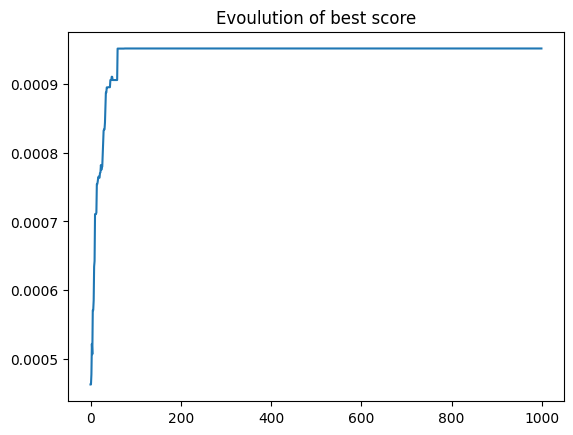

In [41]:
plt.plot(np.arange(n_gen), [history[i][0] for i in range(n_gen)])
plt.title('Evoulution of best score')
plt.show()

Let's plot the solution found by the GA. 

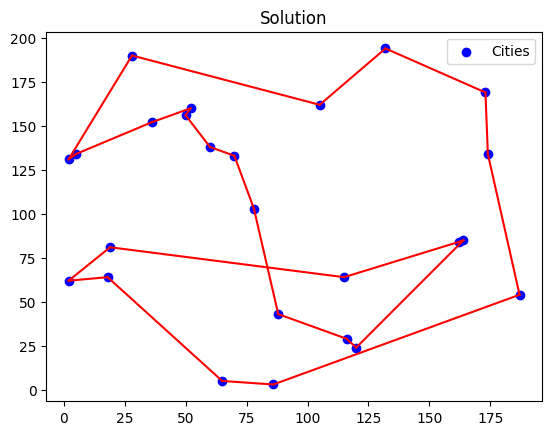

In [42]:
# PLOT THE ROUTE
route = res[1]

x = [city.x for city in route]
y = [city.y for city in route]
plt.scatter(x, y, label='Cities', color='blue')

for i in range(len(cities) - 1):
    plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'r-')
plt.plot([x[len(cities)-1], x[0]], [y[len(cities)-1], y[0]], 'r-')

plt.title('Solution')
plt.legend()
plt.show()

In [39]:
from ipywidgets import interactive, IntSlider

routes_history = [history[i][1] for i in range(n_gen)]

def plot_history( routes_history, cool=False):
        
        def plot_iteration(it):
            color = "black"
            if cool == True:
                plt.style.use("dark_background")
                color = "white"

            route = routes_history[it]
            x = [city.x for city in route]
            y = [city.y for city in route]
            plt.scatter(x, y, label='Cities', color='blue')

            for i in range(len(cities) - 1):
                plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'r-')
            plt.plot([x[len(cities)-1], x[0]], [y[len(cities)-1], y[0]], 'r-')
            plt.title(f'Generation {it}')
    
            plt.legend()
            plt.show()

        plt.style.use("default")

        slider = IntSlider(min=0, max=n_gen-1, step=1, value=0)
        return interactive(plot_iteration, it=slider)

plot_history(routes_history=routes_history, cool=False)

interactive(children=(IntSlider(value=0, description='it', max=999), Output()), _dom_classes=('widget-interact…